In [1]:
import pandas as pd
import os
import classify
from start import data_path
import numpy as np
import extract_laws
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.linear_model import Lasso
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.

In [2]:
resample = False
resample = False
resample = False
resample = False
if resample:
    text_scraped = pd.read_csv(os.path.join(data_path, 'text_scraped.csv'))
    docs_to_label = text_scraped[['title', 'text', 'link']].sample(n = 700)
    docs_to_label['label'] = ''
    docs_to_label = docs_to_label[['title', 'label', 'text', 'link']]
    docs_to_label.to_csv(os.path.join(data_path, 'docs_to_label_curves.csv'))
    print('resampled')
    docs_to_label

In [3]:
labeled_docs = pd.read_csv(os.path.join(data_path, 'docs_to_label_curves_labelled.csv'))
print(labeled_docs['label'].value_counts())
labeled_docs = labeled_docs[(labeled_docs.label == True) | (labeled_docs.label == False)]
len(labeled_docs)

False    478
True     121
Name: label, dtype: int64


599

In [4]:
docs_true = pd.read_csv(os.path.join(data_path, 'text_scraped.csv'))
docs_true = docs_true[docs_true.level == 'First']
docs_true = docs_true[docs_true.text != 'UNAVAILABLE']
docs_true = docs_true[docs_true.text != 'No text']
docs_true = docs_true[~docs_true.text.str.contains('Page Not Found')]
docs_true['label'] = True
docs_true = docs_true[['text', 'label']]

In [5]:
n_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]

In [88]:
data_path

'../../data/plans'

# Dictionary

In [89]:
precisions = []
recalls = []
fmeasures = []
dict_docs = docs_true[labeled_docs.label == True].head(20)
dict_docs['laws'] = dict_docs.text.apply(extract_laws.get_laws)
test = labeled_docs.head(100)

repeat_laws = []
for l in dict_docs.laws:
    repeat_laws = repeat_laws + l
laws = []
for law in repeat_laws:
    if law not in laws:
        laws.append(str(law))
test['keyword'] = np.where(test.text.str.contains("District of Innovation") &
                               (test.text.str.contains('|'.join(laws))), True, False)

tp = len(test[(test.label == True) & (test.keyword == True)])
fp = len(test[(test.label == False) & (test.keyword == True)])
tn = len(test[(test.label == False) & (test.keyword == False)])
fn = len(test[(test.label == True) & (test.keyword == False)])

precision = tp/(tp+fp)
recall = tp/(tp+fn)
fmeasure = 2 * ((precision*recall)/(precision+recall))
for n in n_list:
    precisions.append(precision)
    recalls.append(recall)
    fmeasures.append(fmeasure)
dict_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions,
     'recall': recalls,
     'fmeasure': fmeasures
    })
dict_scores.to_csv(os.path.join(data_path, 'dict_performance.csv'))
dict_scores

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,N,precision,recall,fmeasure
0,20,0.846154,0.916667,0.88
1,40,0.846154,0.916667,0.88
2,60,0.846154,0.916667,0.88
3,80,0.846154,0.916667,0.88
4,100,0.846154,0.916667,0.88
5,120,0.846154,0.916667,0.88
6,140,0.846154,0.916667,0.88
7,160,0.846154,0.916667,0.88
8,180,0.846154,0.916667,0.88
9,200,0.846154,0.916667,0.88


# Linear and SVM

In [90]:
def split_data(data, train_n = 200):
    test_n = 85
    n = train_n + test_n
    test = data.head(test_n)
    train = data.tail(train_n)
    print('The last', str(train_n), 'documents are used for training. Training dataset statistics:')
    print(train['label'].value_counts())
    print('The first', str(test_n), 'documents are used for testing. Testing dataset statistics:')
    print(test['label'].value_counts())
    return train, test
train, test = split_data(labeled_docs, 20)

The last 20 documents are used for training. Training dataset statistics:
False    13
True      7
Name: label, dtype: int64
The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64


In [91]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    """
    Train an arbitrary sklearn classifier.
    
    Args:
        classified: sklearn.Classifier
            The Generalized classifier object to train
        feature_vector_train: ???
            The features on the training set to use to train the classifier.
        label_train: ???
            The labels on the training set to use to train the classifier.
        feature_vector_valid: ???
            The features on the validation set to use to test the classifier.
        label_valid: ???
            The labels on the validation set to use to test the classifier.
            
    Returns: tuple(float, float, float)
        The precisions score, recall score, and f1 score for the classifier against 
        the validation set.
        
    """
    
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)        
    
    #return metrics.accuracy_score(predictions, valid_y)
    return metrics.precision_score(predictions, label_valid), metrics.recall_score(predictions, label_valid), metrics.f1_score(predictions, label_valid)
    #return np.asarray(labels)

# Choose lasso penalty

In [92]:
penalty = [0.01, 1,  2, 3, 4,5 ,6 ,7, 8, 9, 10, 11, 12, 13, 14,15, 20, 30, 40, 50]
n = 200
sample = n // 2   

valid_text = labeled_docs.text.head(100)
valid_label = labeled_docs.label.head(100)
train_text = labeled_docs.text.tail(sample)
train_label = labeled_docs.label.tail(sample)
train_text = train_text.append(docs_true.text.head(sample))
train_label = train_label.append(docs_true.label.head(sample))

In [93]:
top_fmeasure = 0
for value in penalty:
 
    # label encode the target variable 
    encoder = preprocessing.LabelEncoder()
    train_label = encoder.fit_transform(train_label)
    valid_label = encoder.fit_transform(valid_label)

    # word level tf-idf
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tfidf_vect.fit(train_text)
    train_tfidf =  tfidf_vect.transform(train_text)
    valid_tfidf =  tfidf_vect.transform(valid_text)

    # Linear
    precision, recall, fmeasure = train_model(
        linear_model.LogisticRegression(penalty = 'l1', C = value ), 
        train_tfidf, 
        train_label, 
        valid_tfidf, 
        valid_label,
    )
    if fmeasure > top_fmeasure:
        top_fmeasure = fmeasure
        best_penalty = value
print(best_penalty)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


6


In [102]:
precisions_lin = []
recalls_lin = []
fmeasures_lin = []
precisions_svm = []
recalls_svm = []
fmeasures_svm = []
for n in n_list:

    
    valid_text = labeled_docs.text.head(100)
    valid_label = labeled_docs.label.head(100)

    # Want to randomly sample from the list of true plans and randomly idenfitied plans at 50-50 balance
    sample = n // 2    
    train_text = labeled_docs.text.tail(sample)
    train_label = labeled_docs.label.tail(sample)
    train_text = train_text.append(docs_true.text.head(sample))
    train_label = train_label.append(docs_true.label.head(sample))
    
    #trainDF = pd.Dataframe()

    # label encode the target variable 
    encoder = preprocessing.LabelEncoder()
    train_label = encoder.fit_transform(train_label)
    valid_label = encoder.fit_transform(valid_label)

    # word level tf-idf
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tfidf_vect.fit(train_text)
    train_tfidf =  tfidf_vect.transform(train_text)
    valid_tfidf =  tfidf_vect.transform(valid_text)
    
    # Logistic
    precision, recall, fmeasure = train_model(
        linear_model.LogisticRegression(penalty = 'l1', C = best_penalty), 
        train_tfidf, 
        train_label, 
        valid_tfidf, 
        valid_label,
    )
    precisions_lin.append(precision)
    recalls_lin.append(recall)
    fmeasures_lin.append(fmeasure)
    
    # SVM on Word-Level TF-IDF Vectors    
    precision, recall, fmeasure = train_model(
        svm.SVC(kernel='linear', shrinking=True), 
        train_tfidf, 
        train_label, 
        valid_tfidf,
        valid_label,
    )
    precisions_svm.append(precision)
    recalls_svm.append(recall)
    fmeasures_svm.append(fmeasure)
    
    # 
lin_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions_lin,
     'recall': recalls_lin,
     'fmeasure': fmeasures_lin
    })
lin_scores.to_csv(os.path.join(data_path, 'lin_performance.csv'))
svm_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions_svm,
     'recall': recalls_svm,
     'fmeasure': fmeasures_svm
    })
svm_scores.to_csv(os.path.join(data_path, 'svm_performance.csv'))

In [103]:
lin_scores

,N,precision,recall,fmeasure
0,20,1.000000,0.666667,0.800000
1,40,1.000000,0.727273,0.842105
2,60,1.000000,0.666667,0.800000
3,80,1.000000,0.888889,0.941176
4,100,1.000000,0.857143,0.923077
5,120,0.958333,0.821429,0.884615
6,140,1.000000,0.827586,0.905660
7,160,1.000000,0.827586,0.905660
8,180,1.000000,0.857143,0.923077
9,200,1.000000,0.888889,0.941176


In [104]:
svm_scores

,N,precision,recall,fmeasure
0,20,1.000000,0.480000,0.648649
1,40,1.000000,0.705882,0.827586
2,60,1.000000,0.648649,0.786885
3,80,1.000000,0.727273,0.842105
4,100,1.000000,0.827586,0.905660
5,120,1.000000,0.705882,0.827586
6,140,1.000000,0.727273,0.842105
7,160,1.000000,0.727273,0.842105
8,180,1.000000,0.750000,0.857143
9,200,1.000000,0.827586,0.905660


# CNN

In [118]:
precisions = []
recalls = []
fmeasures = []
for n in n_list:
    sample = int(n*.5)
    sample_docs = labeled_docs.head(sample + 85)
    sample_docs = sample_docs.append(docs_true.head(sample), ignore_index = True, sort = False)
    print('The first 85 documents are used for testing. Testing dataset statistics:')
    print(sample_docs.head(85)['label'].value_counts())
    print('The last n of documents are used for training. Training dataset statistics:')
    print(sample_docs.tail(n)['label'].value_counts())

    texts, cats = classify.reformat_cat_from_df(df = sample_docs,
                                          text_col = 'text',
                                          label_col = 'label',
                                          category = 'INNOVATION')
    output_dir = os.path.join(data_path, 'document_classifier_n' + str(n))
    precision, recall, fmeasure = classify.train_classifier_and_evaluate(texts=texts, 
                                            cats=cats, 
                                            n_test = 85,
                                            model=None, 
                                            output_dir=output_dir, 
                                            n_iter=10, 
                                            categories=['INNOVATION'])
    precisions.append(precision)
    recalls.append(recall)
    fmeasures.append(fmeasure)
cnn_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions,
     'recall': recalls,
     'fmeasure': fmeasures
    })
cnn_scores.to_csv(os.path.join(data_path, 'cnn_performance2.csv'))

The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64
The last n of documents are used for training. Training dataset statistics:
True     13
False     7
Name: label, dtype: int64
Created blank 'en' model
First of test 20    2012-13 Texas Academic Performance Report2012-...
21                                              No text
22    Michael S. Kuhrt, Superintendent 1104 Broad • ...
23    Google Drive: Sign-in Sign in to continue to G...
24                        Not Found Not Found Error 404
Name: text, dtype: object
Using 105 examples (20 training, 85 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
1.724	0.625	0.962	0.758
0.383	0.605	1.000	0.754
0.377	0.619	1.000	0.765
0.202	0.641	0.962	0.769
0.014	0.632	0.923	0.750
0.001	0.625	0.962	0.758
0.050	0.610	0.962	0.746
0.004	0.625	0.962	0.758
0.000	0.625	0.962	0.758
0.000	0.641	0.962	0.769
No text {'INNOVATION': 4.539787187241018e-05}
Saved model to ../../data/

2.262	1.000	0.890	0.942
0.945	1.000	0.932	0.965
0.309	1.000	0.918	0.957
0.477	1.000	0.918	0.957
0.348	1.000	0.890	0.942
0.258	1.000	0.904	0.950
0.254	1.000	0.918	0.957
0.250	1.000	0.918	0.957
0.261	1.000	0.918	0.957
No text {'INNOVATION': 4.539787187241018e-05}
Saved model to ../../data/plans/document_classifier_n70
Loading from ../../data/plans/document_classifier_n70
No text {'INNOVATION': 4.539787187241018e-05}
The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64
The last n of documents are used for training. Training dataset statistics:
True     96
False    64
Name: label, dtype: int64
Created blank 'en' model
First of test 160    1 Pampa ISD District of Innovation Plan Introd...
161                                              No text
162    HAWLEY ISD Proposed 2017-2018 Budget General O...
163                                          UNAVAILABLE
164    Lubbock Independent School District 1628 19th ...
Name: tex

8.122	1.000	0.929	0.963
3.080	1.000	0.906	0.951
2.092	1.000	0.918	0.957
1.481	1.000	0.929	0.963
0.878	1.000	0.953	0.976
0.616	1.000	0.941	0.970
0.842	1.000	0.941	0.970
0.536	1.000	0.929	0.963
0.260	1.000	0.918	0.957
0.286	1.000	0.929	0.963
No text {'INNOVATION': 4.539787187241018e-05}
Saved model to ../../data/plans/document_classifier_n140
Loading from ../../data/plans/document_classifier_n140
No text {'INNOVATION': 4.539787187241018e-05}
The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64
The last n of documents are used for training. Training dataset statistics:
True     183
False    117
Name: label, dtype: int64
Created blank 'en' model
First of test 300    Chico Independent School District P.O. Box 95 ...
301    1 May ISD District of Innovation Plan Start Da...
302    Malakoff Independent School District Committed...
303    BRIDGE CITY ISD District of Innovation Plan Ap...
304    Comanche ISD District of Innova

# Graph

In [99]:
dict_fmeasure = pd.read_csv(os.path.join(data_path, 'dict_performance.csv'))
lin_fmeasure = pd.read_csv(os.path.join(data_path, 'lin_performance.csv'))
svm_fmeasure = pd.read_csv(os.path.join(data_path, 'svm_performance.csv'))
cnn_fmeasure = pd.read_csv(os.path.join(data_path, 'cnn_performance2.csv'))
dict_fmeasure = dict_fmeasure[dict_fmeasure.N <= 300]
lin_fmeasure = lin_fmeasure[lin_fmeasure.N <= 300]
svm_fmeasure = svm_fmeasure[svm_fmeasure.N <= 300]
cnn_fmeasure = cnn_fmeasure[cnn_fmeasure.N <= 300]

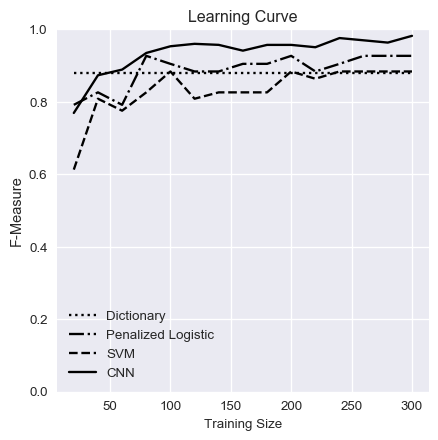

In [101]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

plt.plot(dict_fmeasure.N, dict_fmeasure.fmeasure, color = 'black', linestyle = ':', label = 'Dictionary')
plt.plot(lin_fmeasure.N, lin_fmeasure.fmeasure, color = 'black', linestyle = '-.', label = 'Penalized Logistic')
plt.plot(svm_fmeasure.N, svm_fmeasure.fmeasure, color = 'black', linestyle = '--', label = 'SVM')
plt.plot(cnn_fmeasure.N, cnn_fmeasure.fmeasure, color = 'black', linestyle = '-', label = 'CNN')

plt.ylabel('F-Measure')
plt.title('Learning Curve')
plt.xlabel('Training Size', size = 'medium')

plt.ylim((0,1))

plt.legend()

plt.savefig(data_path + 'learning.png', dpi = 600, bbox_inches="tight")